# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.

In [25]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

---
## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:
- The high-probability region is thin and curved
- Random walk proposals often step off the ridge
- Samplers need to follow the curved geometry efficiently

In [26]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

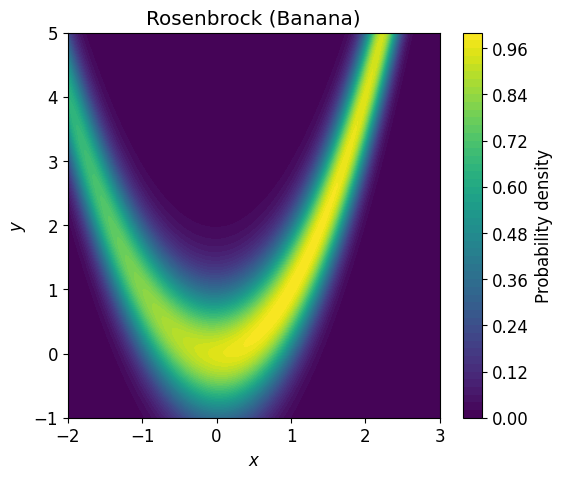

In [27]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---
## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.

In [28]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.

In [29]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    hmc = blackjax.hmc(
        log_prob_fn,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=n_leapfrog,
    )
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state)
        return state, (state.position, info.acceptance_rate)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Run Baselines on Rosenbrock

In [30]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 74.78%


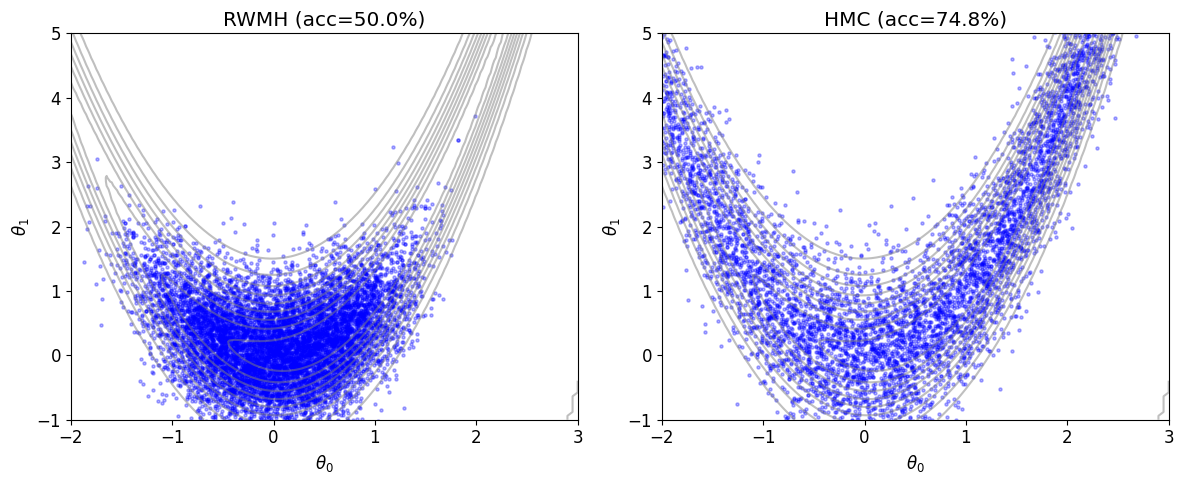

In [31]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---
## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:
- **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
- **Effective Sample Size (ESS)**: How many independent samples you effectively have
- **Trace plots**: Visual check for mixing and stationarity
- **Autocorrelation**: How correlated successive samples are

In [32]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata))

In [33]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)

arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.048,0.637,-1.105,1.206,0.005,0.003,16997.0,17579.0,NaN
y,0.266,0.659,-0.982,1.497,0.005,0.004,18094.0,17114.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.456,2.202,-3.390,4.018,0.294,0.121,42.0,36.0,NaN
y,4.970,5.012,-0.379,15.324,0.593,0.459,93.0,61.0,NaN


RWMH Trace Plots:


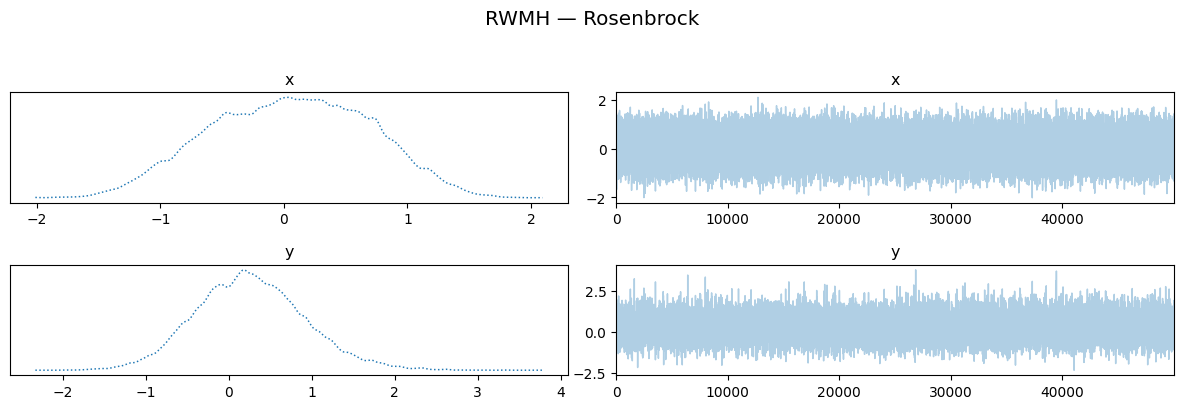


HMC Trace Plots:


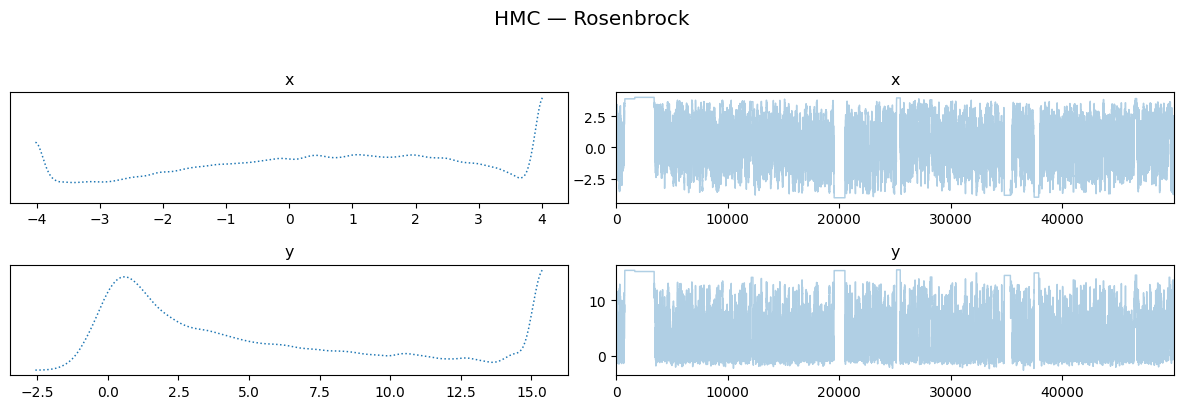

In [34]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

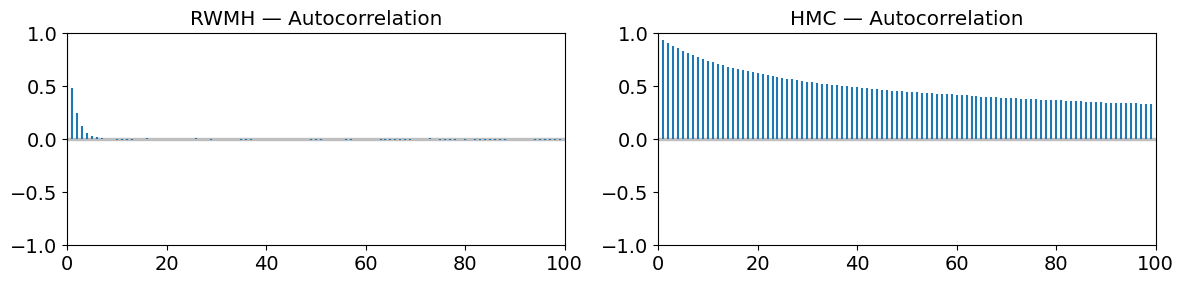

In [35]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has *lower* autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:
- If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
- If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly *within* its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.

---
## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:
- When $v$ is large and positive, $x$ can vary widely
- When $v$ is large and negative, $x$ is tightly constrained near 0
- A single step size can't work well everywhere

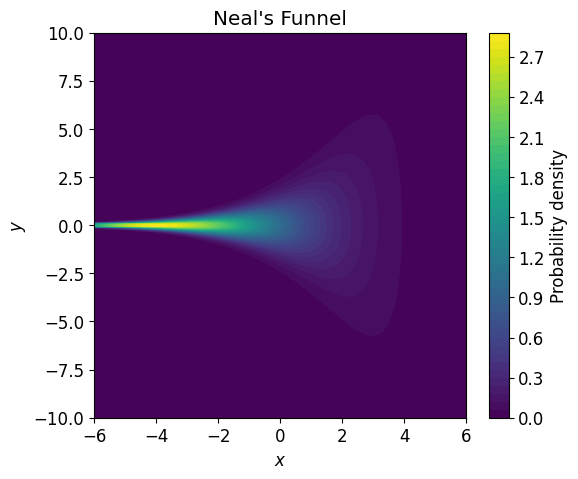

In [36]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

RWMH acceptance rate (Funnel): 65.31%
HMC acceptance rate (Funnel): 78.51%


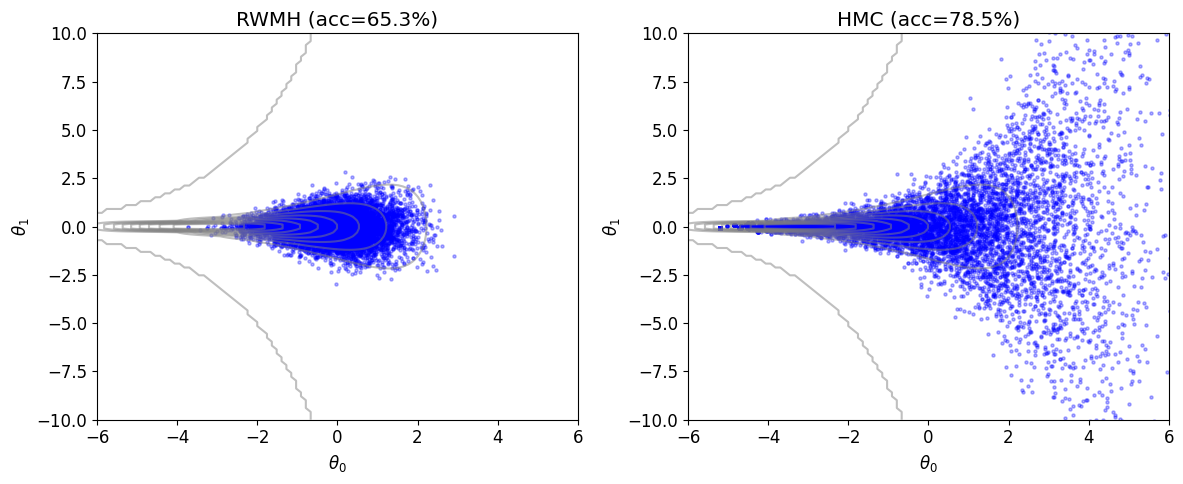

In [37]:
# TODO: Run the RWMH and HMC baselines on Neal's Funnel
# Use the same workflow as Rosenbrock above — you'll need to tune hyperparameters!

key3, key4 = jr.split(jr.PRNGKey(123))
initial_pos_funnel = jnp.array([0.0, 0.0])

rwmh_funnel_samples, rwmh_funnel_acc = run_rwmh(
    key3, log_prob_funnel, initial_pos_funnel, sigma=1.0, n_samples=50_000
)
print(f"RWMH acceptance rate (Funnel): {rwmh_funnel_acc:.2%}")

hmc_funnel_samples, hmc_funnel_acc = run_hmc(
    key4, log_prob_funnel, initial_pos_funnel,
    step_size=0.3,  n_leapfrog=5,  n_samples=50_000
)
print(f"HMC acceptance rate (Funnel): {hmc_funnel_acc:.2%}")

plot_samples_comparison(
    rwmh_funnel_samples, hmc_funnel_samples,
    f"RWMH (acc={rwmh_funnel_acc:.1%})",
    f"HMC (acc={hmc_funnel_acc:.1%})",
    log_prob_funnel, xlim=(-6, 6), ylim=(-10, 10),
)

---
## Your Novel Sampler

Now it's your turn! Implement your own sampler below. Some ideas:

- **Adaptive proposals**: Adjust step size based on acceptance rate or local curvature
- **Hybrid methods**: Combine different move types (e.g., local + global moves)
- **Modified dynamics**: Change the Hamiltonian, use different integrators, add friction
- **Tempering**: Use temperature schedules to help exploration

A simple idea with thorough analysis beats a complex idea you don't understand!

In [38]:
# TODO: Test your sampler on both benchmarks (Rosenbrock and Neal's Funnel)
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)

def run_mala_global(key, log_prob_fn, initial_position,
                    step_size, sigma_global, jump_prob, n_samples):
    """Hybrid MALA + Global Jump sampler (Mixture of Kernels).

    Each step:
      - With prob (1 - jump_prob): MALA local step (gradient-guided)
          theta\'  = theta + (eps^2/2)*grad_log_p(theta) + eps*eta, eta~N(0,I)
          Metropolis-corrected with asymmetric proposal ratio.
      - With prob jump_prob: Global random jump (large-sigma RWMH)
          theta\'  ~ N(theta, sigma_global^2 * I)
          Standard symmetric Metropolis correction.

    Both kernels leave the target invariant. The mixture keeps the chain
    ergodic and allows global mode-hopping while MALA efficiently explores
    locally along curved ridges.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function theta -> scalar
        initial_position: Starting point, shape (D,)
        step_size: MALA step size epsilon (tune for ~57% acceptance)
        sigma_global: Std dev for global jump proposals (large, e.g. 2-5)
        jump_prob: Probability of taking a global jump each step (e.g. 0.1)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Overall fraction of accepted proposals
    """

    def mala_log_q(theta_from, theta_to, grad_from):
        """Log density of MALA proposal: N(theta + eps^2/2 * grad, eps^2 * I)."""
        diff = theta_to - theta_from - 0.5 * step_size**2 * grad_from
        return -0.5 * jnp.sum(diff**2) / step_size**2

    def one_step(state, key):
        theta, lp_curr = state
        key_type, key_prop, key_accept = jr.split(key, 3)

        do_jump = jr.uniform(key_type) < jump_prob

        def mala_step(_):
            """Gradient-guided local move with asymmetric MH correction."""
            _, grad_curr = jax.value_and_grad(log_prob_fn)(theta)
            eta = jr.normal(key_prop, theta.shape)
            theta_prop = theta + 0.5 * step_size**2 * grad_curr + step_size * eta
            lp_prop = log_prob_fn(theta_prop)
            _, grad_prop = jax.value_and_grad(log_prob_fn)(theta_prop)
            # MH correction: log alpha = log p(theta\') + log q(theta\'->theta)
            #                           - log p(theta)  - log q(theta->theta\')
            log_q_fwd = mala_log_q(theta, theta_prop, grad_curr)
            log_q_bwd = mala_log_q(theta_prop, theta, grad_prop)
            log_alpha = (lp_prop + log_q_bwd) - (lp_curr + log_q_fwd)
            return theta_prop, lp_prop, log_alpha

        def global_step(_):
            """Large isotropic jump with symmetric MH correction."""
            theta_prop = theta + sigma_global * jr.normal(key_prop, theta.shape)
            lp_prop = log_prob_fn(theta_prop)
            # Symmetric proposal -> log alpha = log p(theta\') - log p(theta)
            log_alpha = lp_prop - lp_curr
            return theta_prop, lp_prop, log_alpha

        # Select branch: do_jump=True -> global_step, False -> mala_step
        theta_prop, lp_prop, log_alpha = jax.lax.cond(
            do_jump, global_step, mala_step, jnp.zeros(()))

        accept = jnp.log(jr.uniform(key_accept)) < log_alpha
        theta_new = jnp.where(accept, theta_prop, theta)
        lp_new   = jnp.where(accept, lp_prop, lp_curr)

        return (theta_new, lp_new), (theta_new, accept)

    initial_state = (initial_position, log_prob_fn(initial_position))
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)
    return samples, accepted.mean()


In [39]:
# TODO: Test your sampler on Rosenbrock
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)

# Hybrid MALA + Global Jump on Rosenbrock
key5, key6 = jr.split(jr.PRNGKey(999))
initial_pos = jnp.array([0.0, 0.0])

hybrid_rosen_samples, hybrid_rosen_acc = run_mala_global(
    key5, log_prob_rosenbrock, initial_pos,
    step_size=0.3, sigma_global=3.0, jump_prob=0.15, n_samples=50_000
)
print(f"Hybrid MALA+Jump acceptance rate (Rosenbrock): {hybrid_rosen_acc:.2%}")


Hybrid MALA+Jump acceptance rate (Rosenbrock): 56.74%


In [40]:
# Hybrid MALA + Global Jump on Neal's Funnel
hybrid_funnel_samples, hybrid_funnel_acc = run_mala_global(
    key6, log_prob_funnel, initial_pos_funnel,
    step_size=0.3, sigma_global=3.0, jump_prob=0.15, n_samples=50_000
)
print(f"Hybrid MALA+Jump acceptance rate (Funnel): {hybrid_funnel_acc:.2%}")


Hybrid MALA+Jump acceptance rate (Funnel): 79.00%


=== Rosenbrock: Three Samplers ===


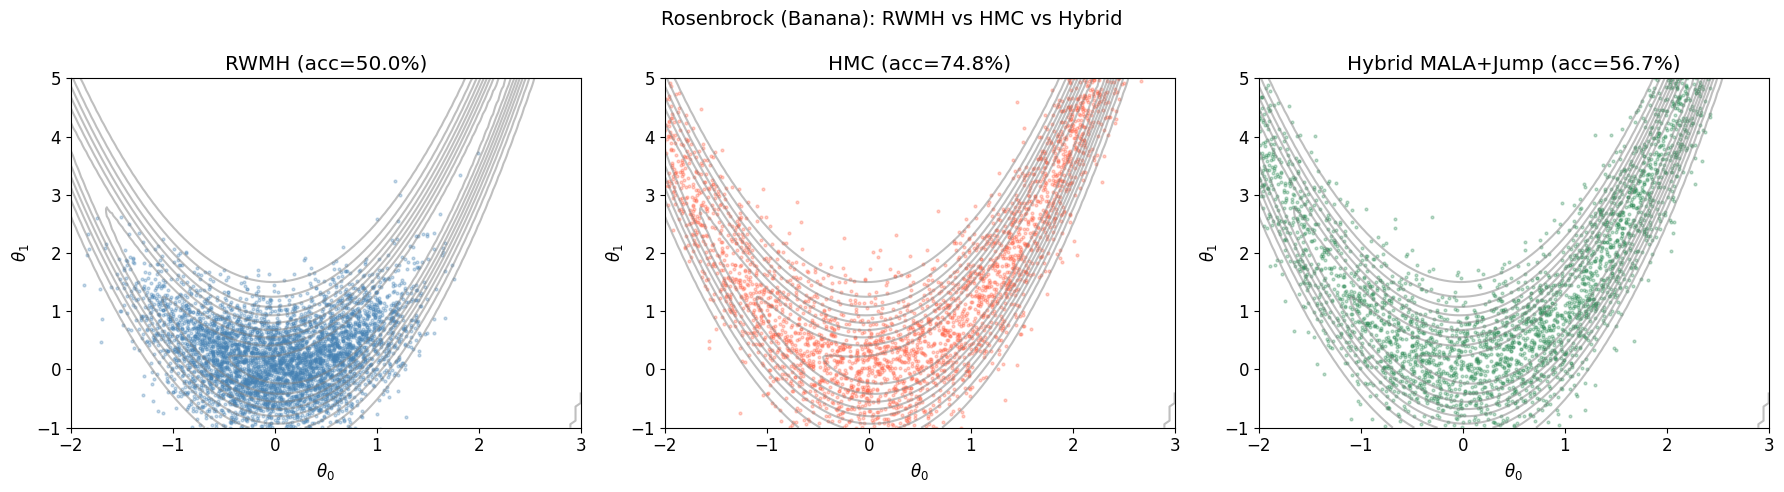

=== Neal's Funnel: Three Samplers ===


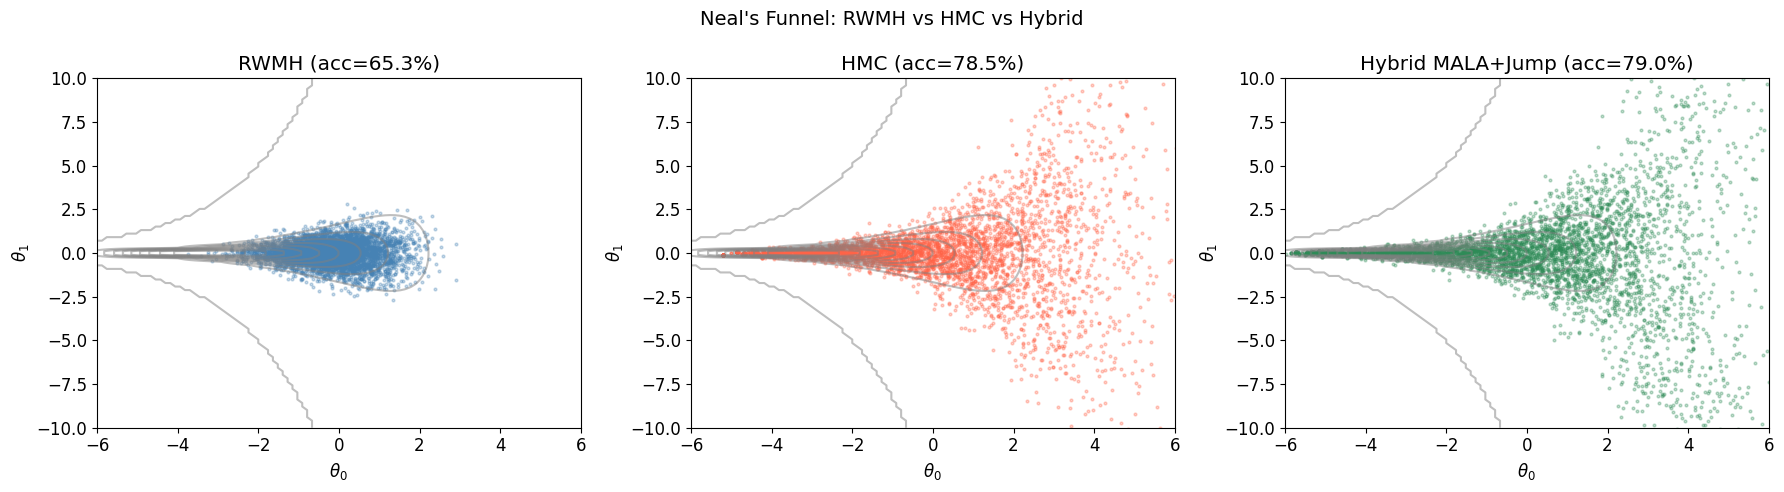

arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== ESS and Summary Statistics: Rosenbrock ===

=== RWMH ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.048,0.637,-1.105,1.206,0.005,0.003,16997.0,17579.0,NaN
y,0.266,0.659,-0.982,1.497,0.005,0.004,18094.0,17114.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== HMC ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.456,2.202,-3.390,4.018,0.294,0.121,42.0,36.0,NaN
y,4.970,5.012,-0.379,15.324,0.593,0.459,93.0,61.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== Hybrid MALA+Jump ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.876,2.090,-3.027,4.282,0.378,0.206,26.0,20.0,NaN
y,5.131,6.316,-1.883,16.370,1.484,1.852,34.0,20.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== ESS and Summary Statistics: Neal's Funnel ===

=== RWMH ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,-0.210,0.907,-1.929,1.478,0.007,0.005,18384.0,11108.0,NaN
x,-0.001,0.675,-1.267,1.307,0.004,0.003,31415.0,34009.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== HMC ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,-0.191,3.263,-5.202,5.137,0.525,0.302,32.0,10.0,NaN
x,2.216,11.137,-9.271,12.223,1.403,3.529,223.0,68.0,NaN


arviz - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)



=== Hybrid MALA+Jump ===


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.516,3.283,-5.503,6.521,0.424,0.238,58.0,41.0,NaN
x,-2.170,10.323,-22.578,9.842,2.807,4.479,57.0,17.0,NaN



=== Trace Plots: Neal's Funnel ===


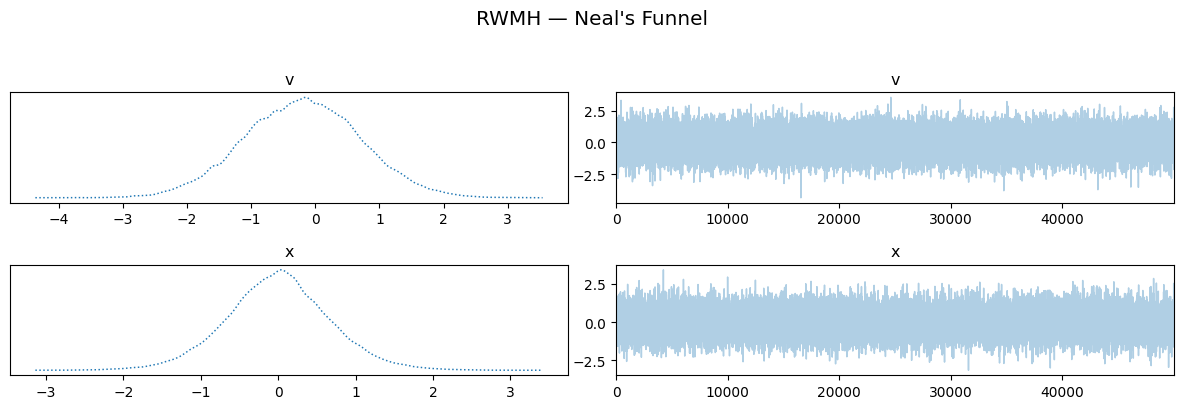

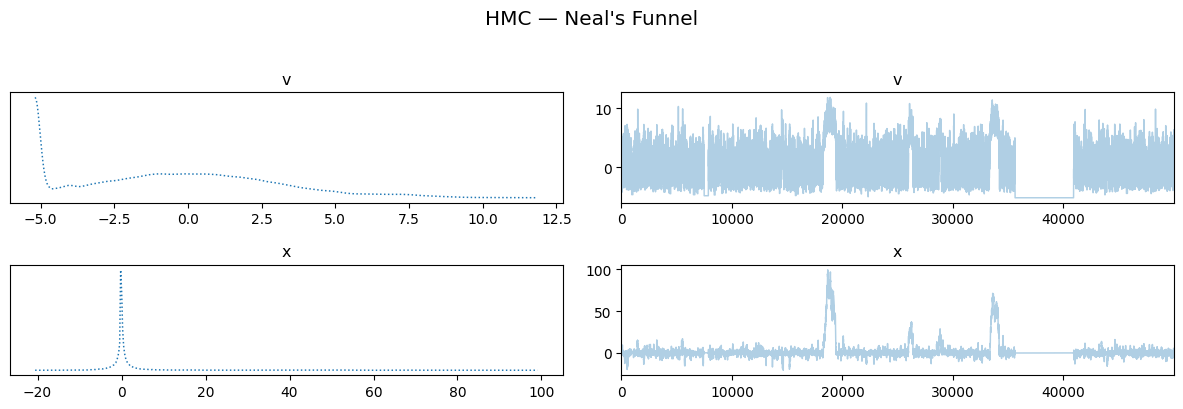

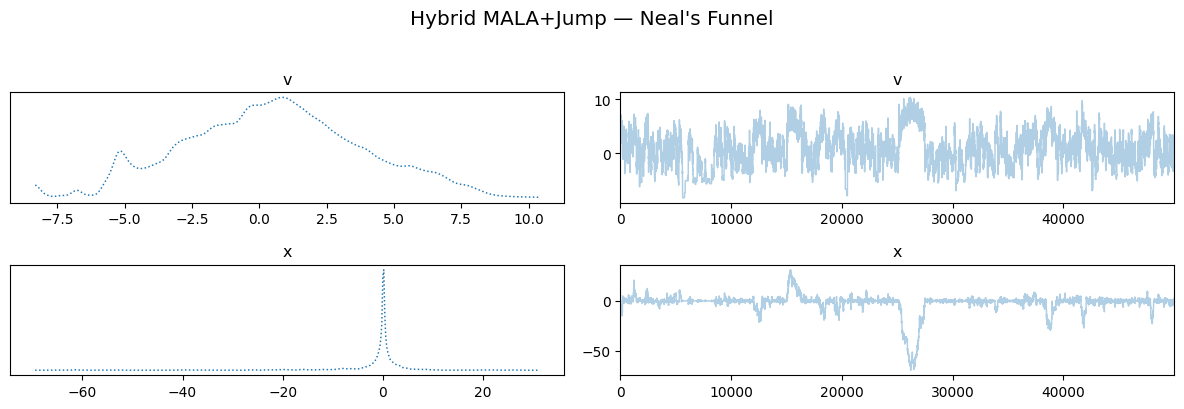


=== Autocorrelation: Neal's Funnel ===


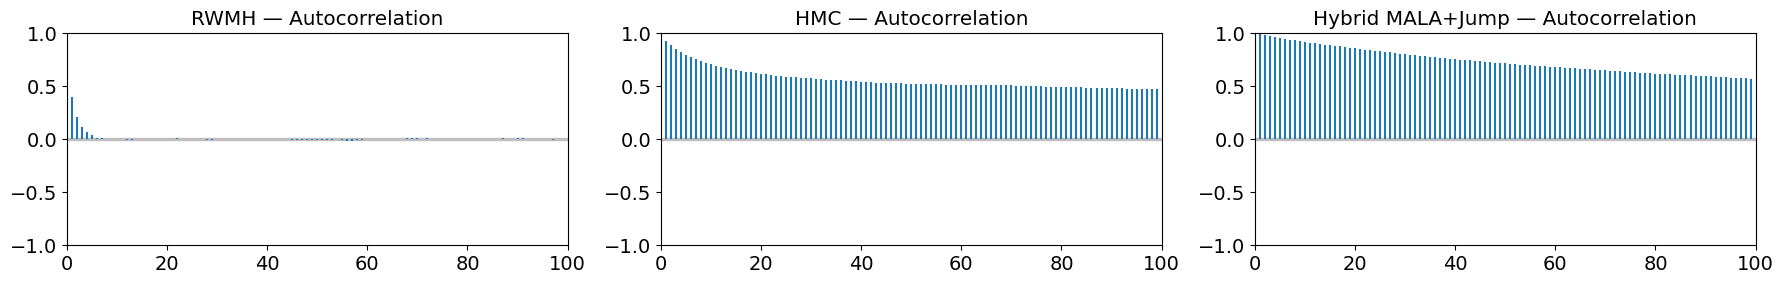

In [41]:
# TODO: Compare to baselines
# - Visualize samples (scatter plot with contours)
# - Compute ESS using samples_to_inference_data() and az.summary()
# - Plot traces and autocorrelation
# - Discuss: where does your method work well? Where does it struggle?

# ============================================================
# Three-Way Comparison: RWMH vs HMC vs Hybrid MALA+Jump
# ============================================================

def plot_three_way(samples_list, labels, log_prob_fn, xlim, ylim, title=""):
    """Scatter plot with contours for three samplers side by side."""
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    colors = ["steelblue", "tomato", "seagreen"]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, samples, label, color in zip(axes, samples_list, labels, colors):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::10, 0], samples[::10, 1], alpha=0.3, s=4, c=color)
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# --- 1. Scatter plots ---
print("=== Rosenbrock: Three Samplers ===")
plot_three_way(
    [rwmh_samples, hmc_samples, hybrid_rosen_samples],
    [f"RWMH (acc={rwmh_acc:.1%})",
     f"HMC (acc={hmc_acc:.1%})",
     f"Hybrid MALA+Jump (acc={hybrid_rosen_acc:.1%})"],
    log_prob_rosenbrock, xlim=(-2, 3), ylim=(-1, 5),
    title="Rosenbrock (Banana): RWMH vs HMC vs Hybrid"
)

print("=== Neal's Funnel: Three Samplers ===")
plot_three_way(
    [rwmh_funnel_samples, hmc_funnel_samples, hybrid_funnel_samples],
    [f"RWMH (acc={rwmh_funnel_acc:.1%})",
     f"HMC (acc={hmc_funnel_acc:.1%})",
     f"Hybrid MALA+Jump (acc={hybrid_funnel_acc:.1%})"],
    log_prob_funnel, xlim=(-6, 6), ylim=(-10, 10),
    title="Neal's Funnel: RWMH vs HMC vs Hybrid"
)

# --- 2. ESS summary tables ---
print("\n=== ESS and Summary Statistics: Rosenbrock ===")
summarize_sampler(rwmh_samples, "RWMH", ["x", "y"])
summarize_sampler(hmc_samples, "HMC", ["x", "y"])
summarize_sampler(hybrid_rosen_samples, "Hybrid MALA+Jump", ["x", "y"])

print("\n=== ESS and Summary Statistics: Neal's Funnel ===")
funnel_var_names = ["v", "x"]
summarize_sampler(rwmh_funnel_samples, "RWMH", funnel_var_names)
summarize_sampler(hmc_funnel_samples, "HMC", funnel_var_names)
summarize_sampler(hybrid_funnel_samples, "Hybrid MALA+Jump", funnel_var_names)

# --- 3. Trace plots: Neal's Funnel (the hard benchmark) ---
print("\n=== Trace Plots: Neal's Funnel ===")
for name, samps in [("RWMH", rwmh_funnel_samples),
                    ("HMC", hmc_funnel_samples),
                    ("Hybrid MALA+Jump", hybrid_funnel_samples)]:
    idata = samples_to_inference_data(samps, funnel_var_names)
    az.plot_trace(idata, combined=True, figsize=(12, 4))
    plt.suptitle(f"{name} — Neal's Funnel", y=1.02)
    plt.tight_layout()
    plt.show()

# --- 4. Autocorrelation comparison: Neal's Funnel ---
print("\n=== Autocorrelation: Neal's Funnel ===")
fig, axes = plt.subplots(1, 3, figsize=(18, 3))
for ax, (name, samps) in zip(axes, [
        ("RWMH", rwmh_funnel_samples),
        ("HMC", hmc_funnel_samples),
        ("Hybrid MALA+Jump", hybrid_funnel_samples)]):
    idata = samples_to_inference_data(samps, funnel_var_names)
    az.plot_autocorr(idata, ax=ax, combined=True)
    ax.set_title(f"{name} — Autocorrelation")
plt.tight_layout()
plt.show()



Ablation: jump_prob sweep on Rosenbrock (eps=0.3, sigma_global=3.0, chains=4)
     q     acc    ESS(x)    ESS(y)    minESS
----------------------------------------------
  0.00  63.12%        35        43        35
  0.05  51.44%        16        16        16
  0.10  42.15%        11        10        10
  0.15  57.06%       196       197       196
  0.20  47.42%        22        29        22
  0.30  46.19%       131       164       131
  0.50  34.61%        66        71        66
  0.70  22.75%       132       119       119
  1.00   8.88%       117        48        48

Limiting cases interpretation:
  q=0.00 => pure MALA (global jump OFF)
  q=1.00 => pure global jump (MALA effectively OFF)
Best q by min(ESSx,ESSy): q=0.15


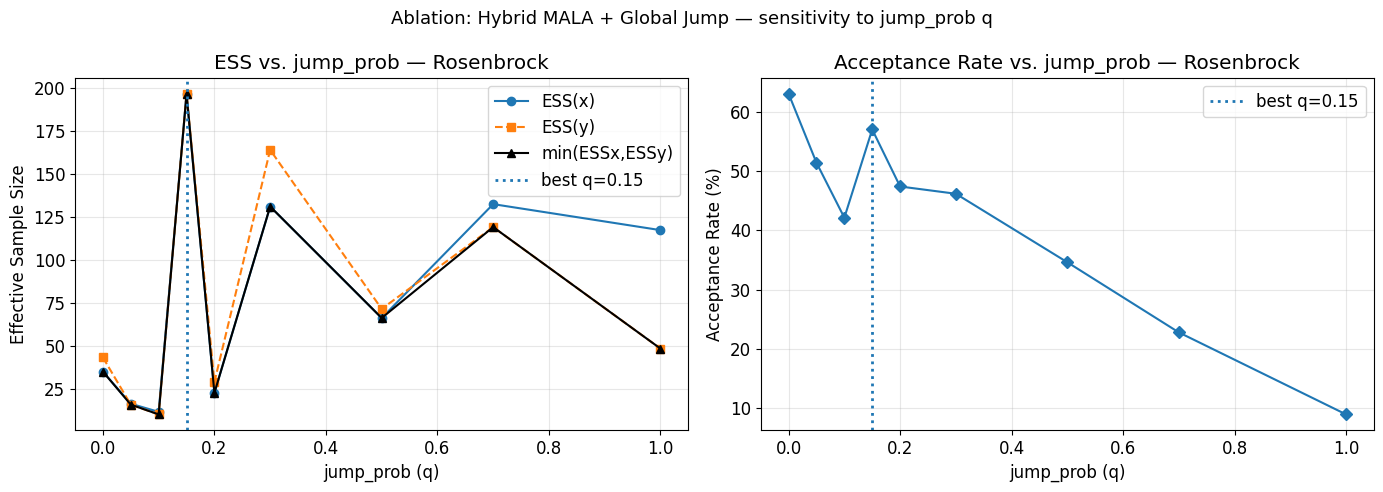

In [42]:
# TODO: Ablation study
# - What are the key hyperparameters of your method?
# - How sensitive is performance to each one?
# - What happens in limiting cases (e.g., turning off a component)?

# TODO: Ablation study (improved)
# - key hyperparams: jump_prob q, step_size eps, sigma_global
# - sensitivity: sweep q (with fixed eps, sigma_global)
# - limiting cases: q=0 (pure MALA), q=1 (pure global jump)

import numpy as np

n_ablation = 50_000
jump_probs = [0.0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1.0]
initial_pos_abl = jnp.array([0.0, 0.0])

eps_fixed = 0.3
sigma_fixed = 3.0
n_chains = 4

ess_x_list, ess_y_list, ess_min_list, acc_list = [], [], [], []

print(f"Ablation: jump_prob sweep on Rosenbrock (eps={eps_fixed}, sigma_global={sigma_fixed}, chains={n_chains})")
print(f"{'q':>6}  {'acc':>6}  {'ESS(x)':>8}  {'ESS(y)':>8}  {'minESS':>8}")
print("-" * 46)

for i, q in enumerate(jump_probs):
    # run multiple chains for more stable ESS
    chain_samples = []
    chain_acc = []
    for c in range(n_chains):
        key_abl = jr.PRNGKey(3000 + 100*i + c)
        s, acc = run_mala_global(
            key_abl, log_prob_rosenbrock, initial_pos_abl,
            step_size=eps_fixed, sigma_global=sigma_fixed, jump_prob=q,
            n_samples=n_ablation
        )
        chain_samples.append(np.array(s))     # (draw, 2)
        chain_acc.append(float(acc))

    chain_samples = np.stack(chain_samples, axis=0)  # (chain, draw, 2)
    mean_acc = float(np.mean(chain_acc))

    # Build ArviZ InferenceData with (chain, draw) per var
    idata = az.from_dict(
        posterior={
            "x": chain_samples[:, :, 0],
            "y": chain_samples[:, :, 1],
        }
    )

    ess = az.ess(idata, method="bulk")  # bulk ESS is standard; could also record tail
    ess_x = float(ess["x"].values)
    ess_y = float(ess["y"].values)
    ess_min = min(ess_x, ess_y)

    ess_x_list.append(ess_x)
    ess_y_list.append(ess_y)
    ess_min_list.append(ess_min)
    acc_list.append(mean_acc)

    print(f"{q:>6.2f}  {mean_acc:>6.2%}  {ess_x:>8.0f}  {ess_y:>8.0f}  {ess_min:>8.0f}")

# pick "best" q by minESS (more conservative)
best_idx = int(np.argmax(ess_min_list))
best_q = jump_probs[best_idx]

print("\nLimiting cases interpretation:")
print(f"  q=0.00 => pure MALA (global jump OFF)")
print(f"  q=1.00 => pure global jump (MALA effectively OFF)")
print(f"Best q by min(ESSx,ESSy): q={best_q:.2f}")

# --- Plot results ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(jump_probs, ess_x_list, "o-",  label="ESS(x)")
ax.plot(jump_probs, ess_y_list, "s--", label="ESS(y)")
ax.plot(jump_probs, ess_min_list, "k^-", label="min(ESSx,ESSy)")
ax.axvline(best_q, linestyle=":", linewidth=2, label=f"best q={best_q:.2f}")
ax.set_xlabel("jump_prob (q)")
ax.set_ylabel("Effective Sample Size")
ax.set_title("ESS vs. jump_prob — Rosenbrock")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(jump_probs, np.array(acc_list) * 100, "D-")
ax.axvline(best_q, linestyle=":", linewidth=2, label=f"best q={best_q:.2f}")
ax.set_xlabel("jump_prob (q)")
ax.set_ylabel("Acceptance Rate (%)")
ax.set_title("Acceptance Rate vs. jump_prob — Rosenbrock")
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle("Ablation: Hybrid MALA + Global Jump — sensitivity to jump_prob q", fontsize=13)
plt.tight_layout()
plt.show()
